## Title: The Prediction of Game Newsletters Subscription Status Based on Age and Number of Played Hours.

## Introduction


<b>Background information:</b> <br>
We are provided with a task to help analyze the dataset collected by a computer science research group at UBC, which includes information about different players that are registered on the server. The research group's main interest is to observe how different people play video games. To help address this question, we have decided to find if we can use the players' age and number of hours spent on the server to predict if they are subscribed to any game newsletters. This is beneficial as it is important to know whether both age and played hours on server are factors that correlate with game newsletter subscription - potentially revealing details about how players with different characteristics enjoy video game contents. 

<b>Question</b>: Can the age and played hours of specific players predict their subscription status to game newsletters in players.csv data? <br>

<b>Dataset included</b>: player.csv

In [1]:
library(tidyverse)
library(ggplot2)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
#reading players file
players <- read.csv("https://raw.githubusercontent.com/Loolin06/dsci-05-27/refs/heads/main/data/players.csv")
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


#### Description about `players` dataset: <br>

This data set contains information on 196 different player accounts. This information includes 7 variables:
- Experience (Beginner, Amateur, Regular, Pro, Veteran). 
- Whether or not they are subscribed.
  - Average 73.5% are subscribed
- The hashed email associated with their account
- Hours spend on the game
  - Average = 5.85 hours
- First name
- Gender
- Age
  - Average = 20.52 years
 
There are some player accounts that are missing a few variables, so it is important that <code>na.rm = TRUE</code> is used so that analysis can be done without issue. Experience, hashed email, name, and gender are in character format. Age and hours played are in double point precision format. Subsriber status is in logical format, which can be quantified as TRUE = 1 and FALSE = 0.


In [3]:
summarize(players, 
          average_age = mean(Age, na.rm = TRUE), 
          average_played_hours = mean(played_hours, na.rm = TRUE))

average_age,average_played_hours
<dbl>,<dbl>
20.52062,5.845918


Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


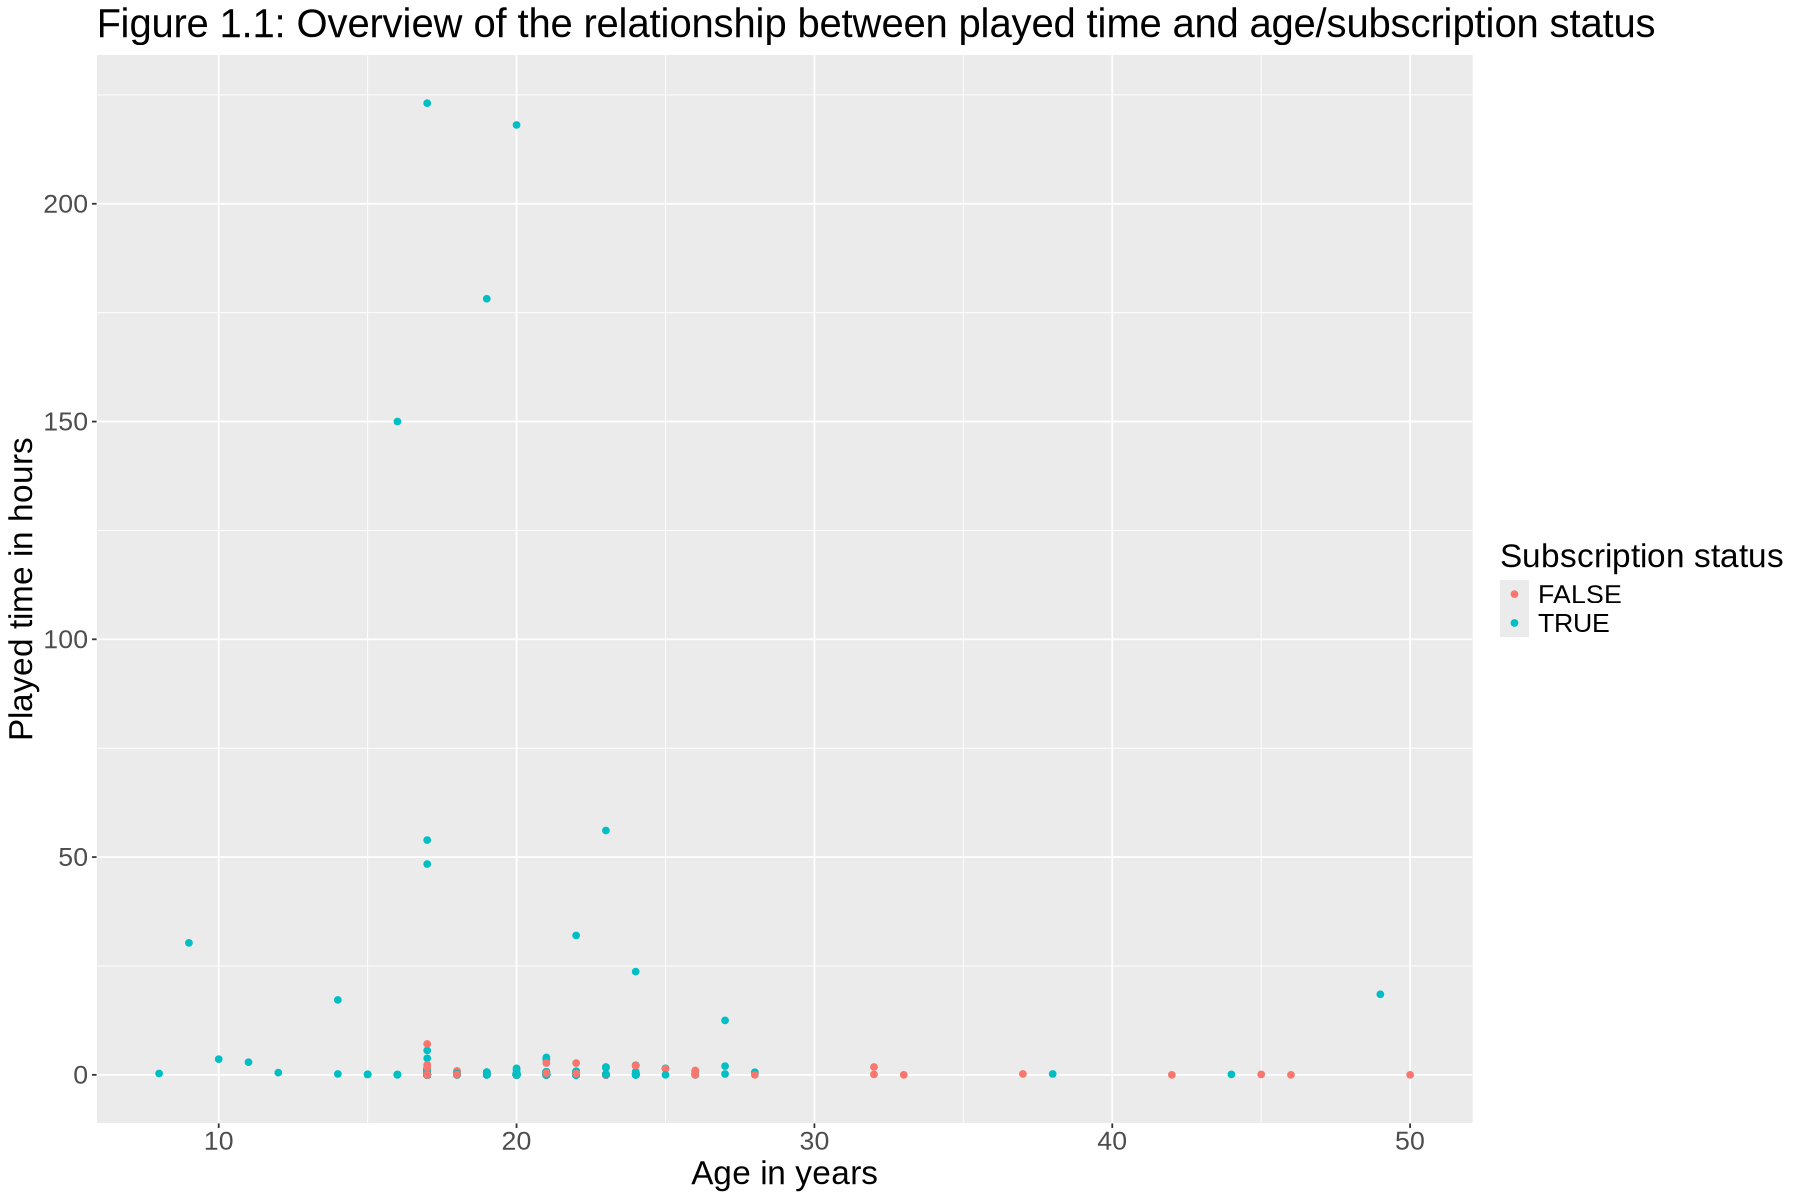

In [4]:
options(repr.plot.width = 15, repr.plot.height = 10)
players_plot <- players |>
    ggplot(aes(x = Age, y = played_hours)) + 
        geom_point(aes(colour = subscribe)) +
        labs(title = "Figure 1.1: Overview of the relationship between played time and age/subscription status",x = "Age in years", y = "Played time in hours", colour = "Subscription status") +
        theme(text = element_text(size=20))
players_plot

#### Explanation of Figure 1.1
The above scatter plot displays the relationship between the variables: played hours, age, and subscription status of the players. The data displays that as age increases, there is a decrease in subscriptions and played hours. Based on this, it can be concluded that majority of players with higher played hours are younger, typically under 30 years old. Also, subscribed players have higher played hours compared to non-subscribed players as evident by the dominance of the blue dots over 10 played hours. 

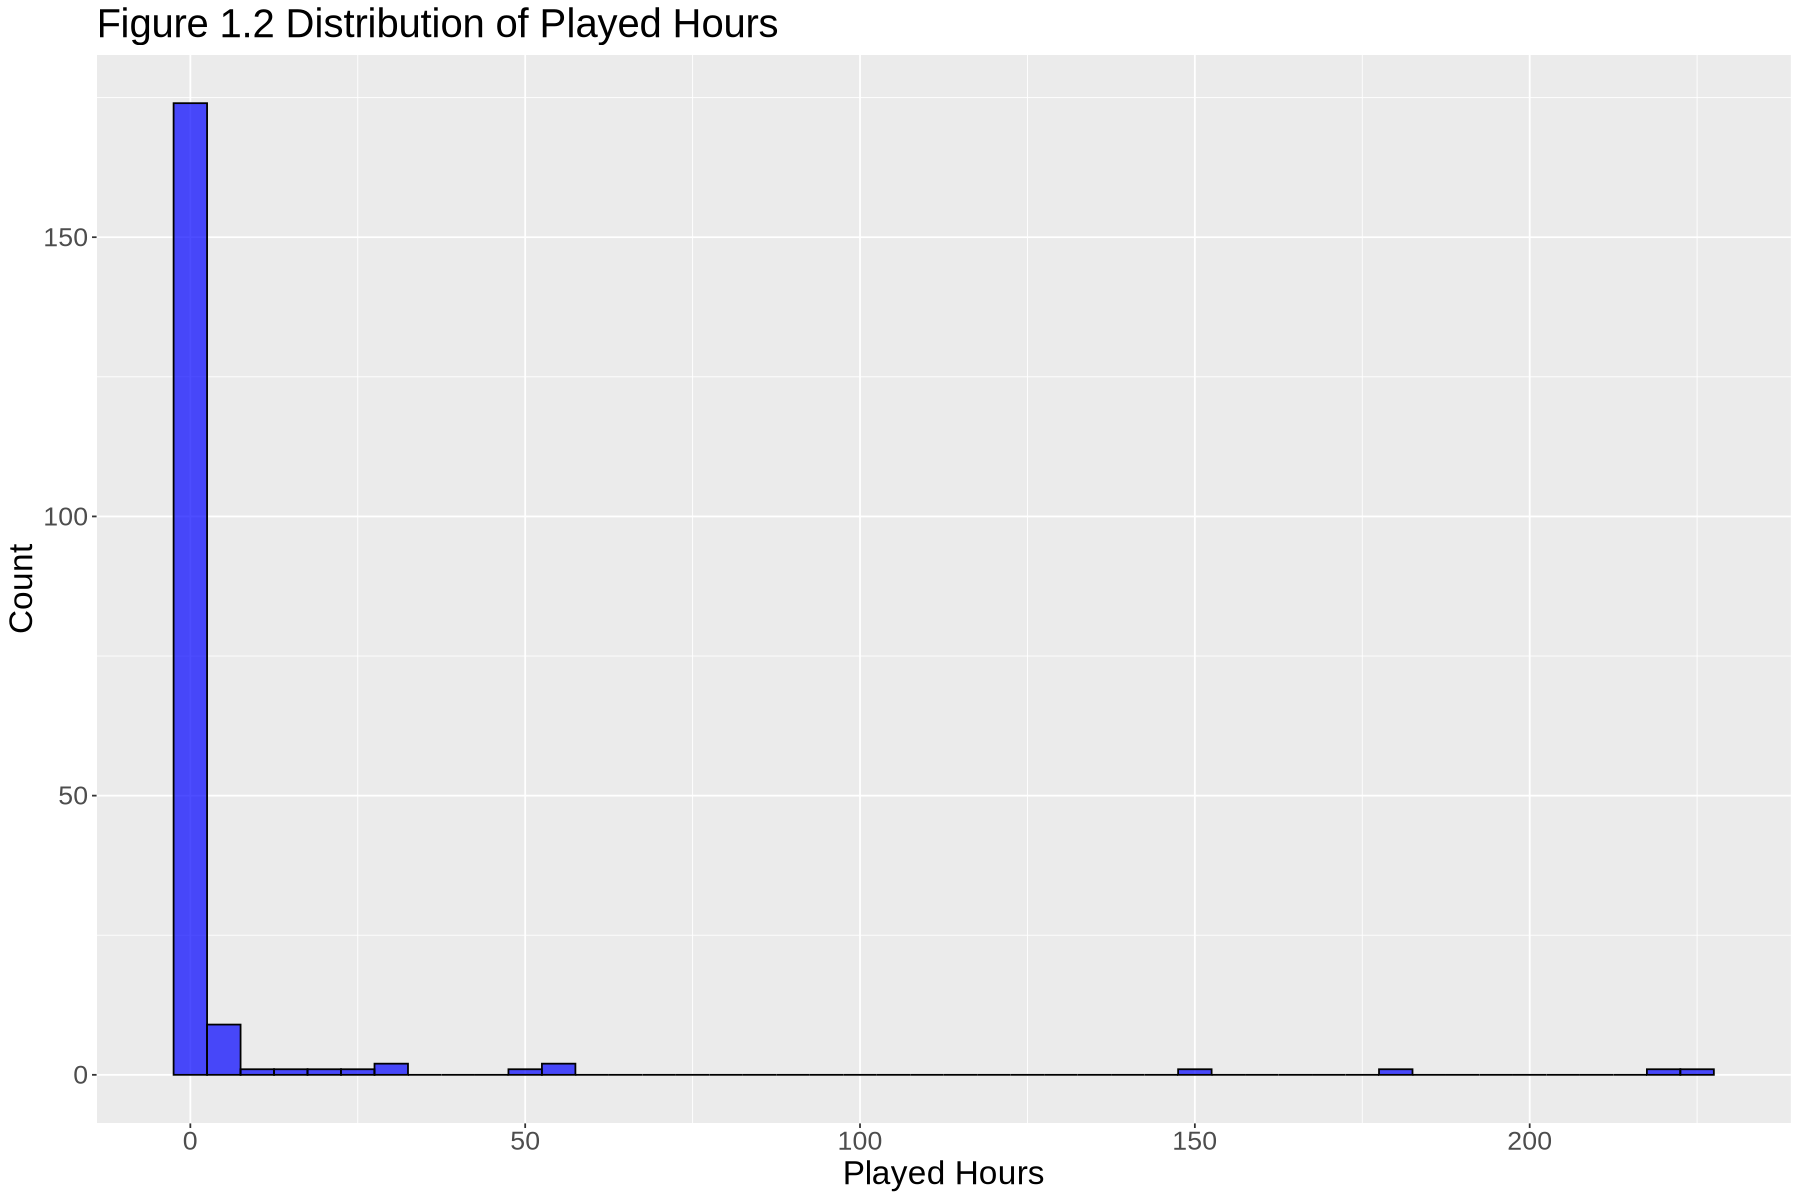

In [5]:
ggplot(players, aes(x = played_hours)) +
  geom_histogram(binwidth = 5, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Figure 1.2 Distribution of Played Hours", x = "Played Hours", y = "Count") + 
  theme(text=element_text(size=20))

#### Explanation of Figure 1.2
The visualization illustrates the distribution of played hours among players, revealing a highly skewed pattern. The majority of players engage with the game for a very short period, as evident from the tall bar near zero played hours. This suggests that a significant portion of users either try the game briefly before leaving or do not engage consistently over time. Meanwhile, there are only a few players with significantly higher played hours, indicating a small but dedicated group of highly engaged users. The gap between these two groups suggests that there are not many players with moderate engagement levels. Most either play very little or commit substantial time to the game.

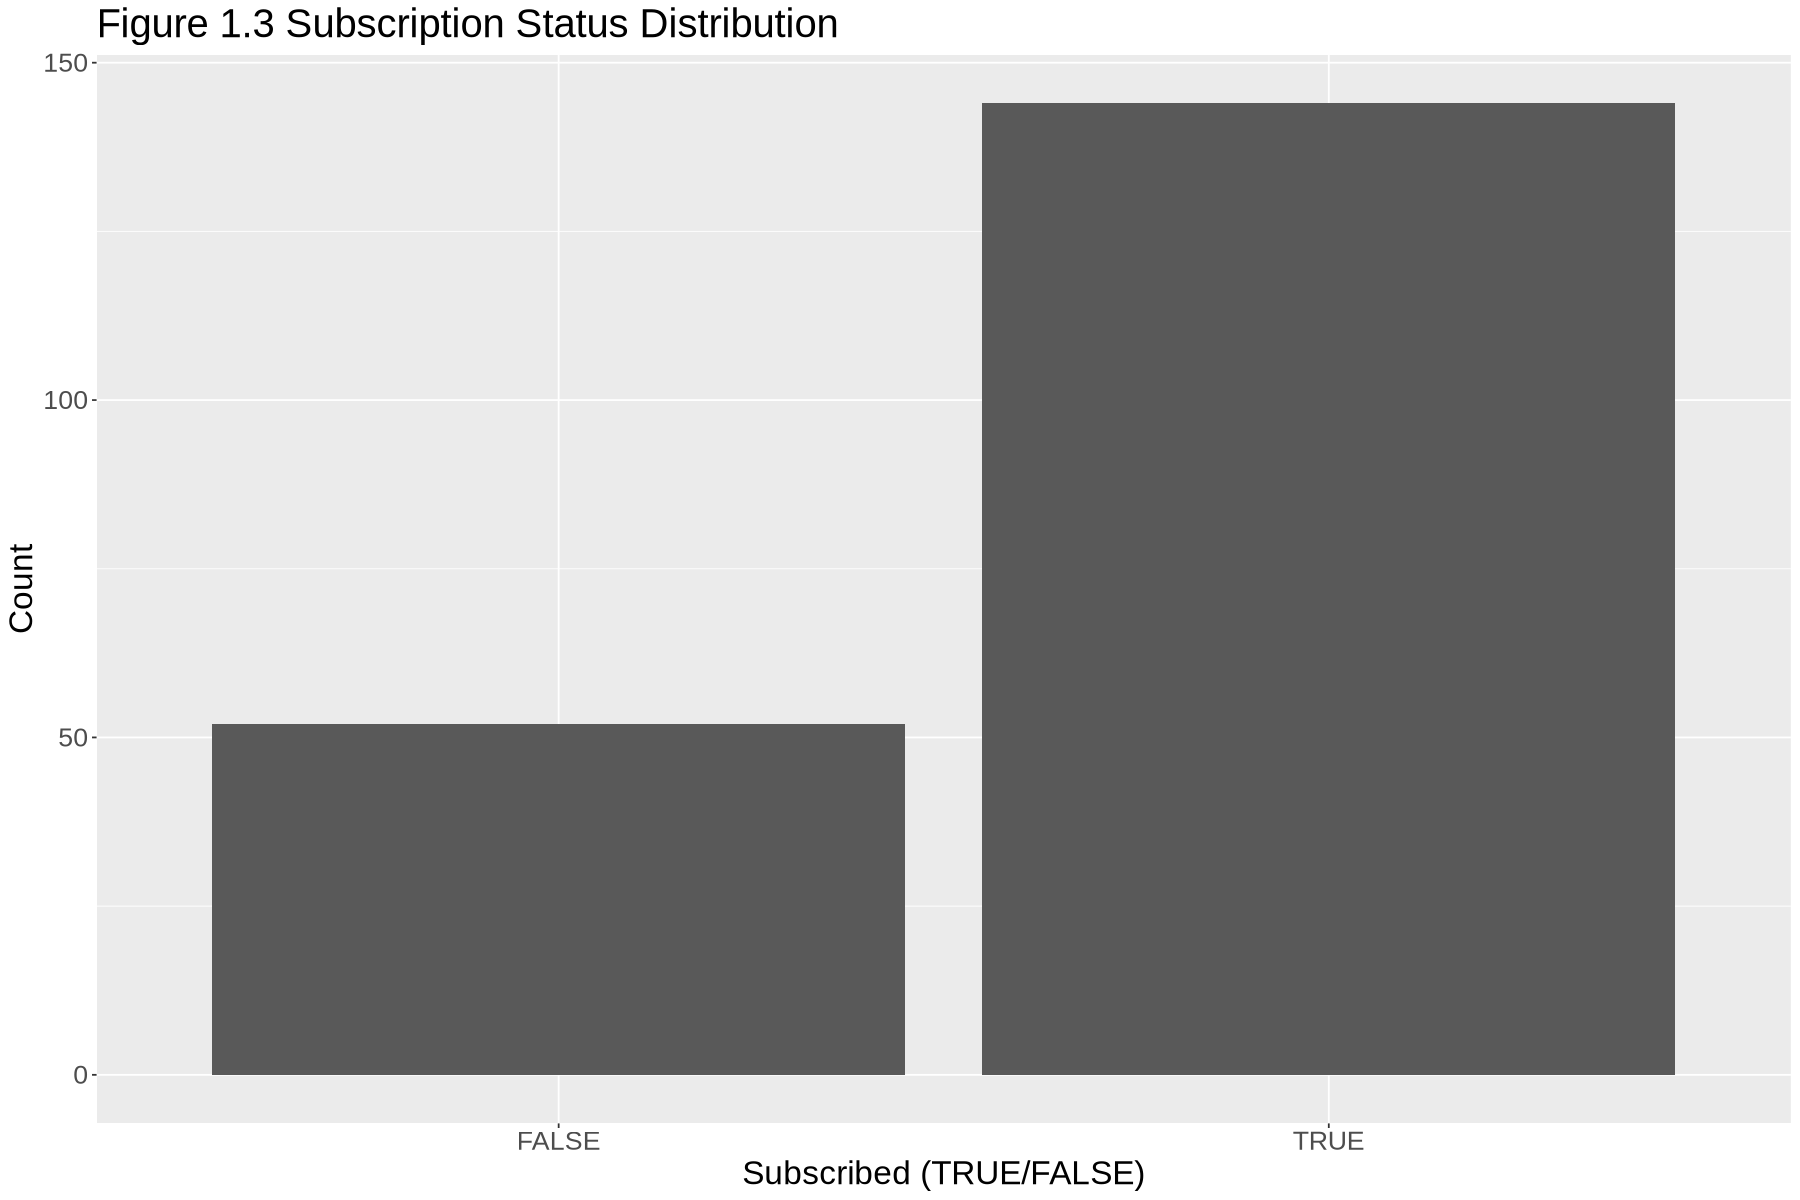

In [6]:
ggplot(players, aes(x = as.factor(subscribe))) +
  geom_bar() +
  labs(title = "Figure 1.3 Subscription Status Distribution", x = "Subscribed (TRUE/FALSE)", y = "Count") +
  theme(text = element_text(size=20))

#### Explanation of Figure 1.3:
This bar graph provides a straightforward visualization of the ratio between subscribed and non-subscribed players. We can clearly see that there is almost triple the number of people who are subscribed than those who are not. This could potentially lead to problems with our k-nn classification models as class imbalances. 

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


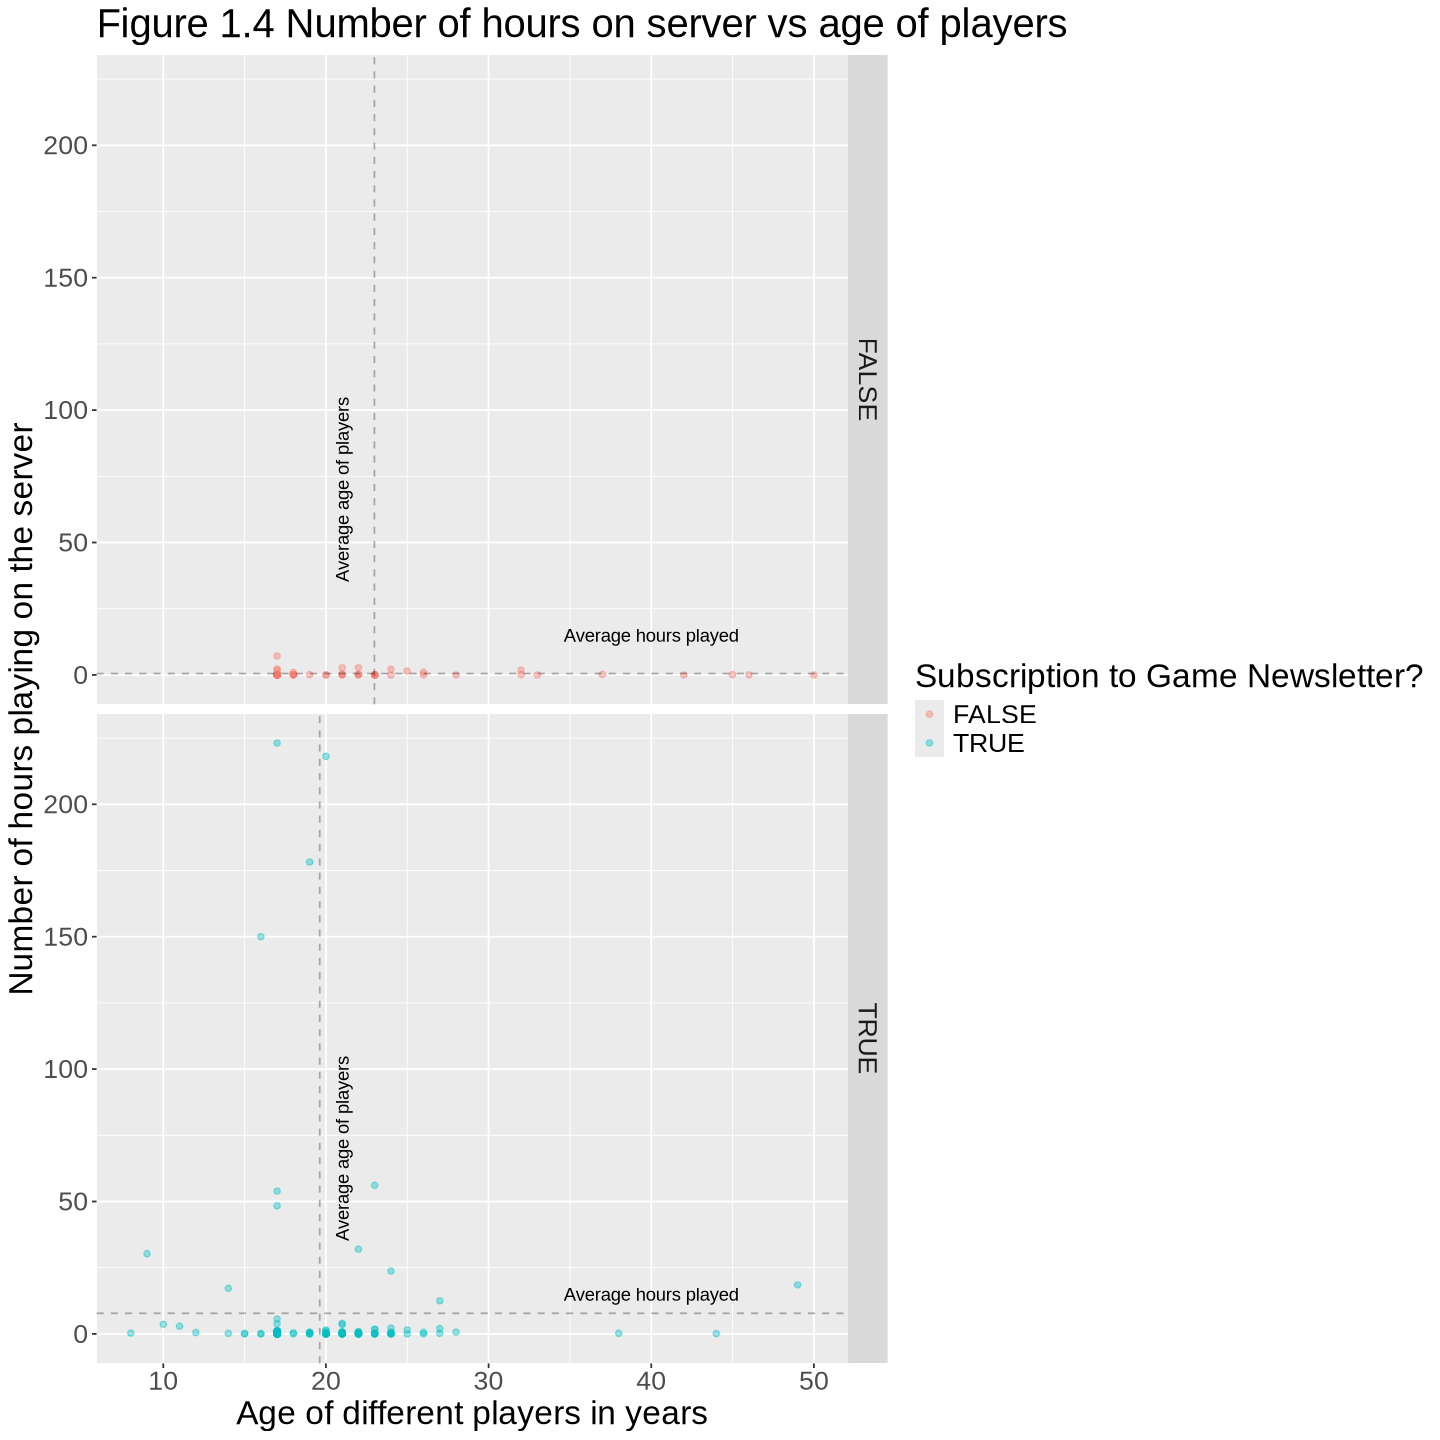

In [7]:
options(repr.plot.width = 12, repr.plot.height = 12)

average_age <- players |>
                select(subscribe, Age) |>
                group_by(subscribe) |>
                summarize(mean=mean(Age, na.rm=TRUE))

average_age_false <- pull(average_age) |> first()
average_age_true <- pull(average_age) |> last()

average_played_hours <- players |>
                        select(subscribe, played_hours) |>
                        group_by(subscribe) |>
                        summarize(mean=mean(played_hours, na.rm=TRUE))

average_played_hours_false <- pull(average_played_hours) |> first()
average_played_hours_true <- pull(average_played_hours) |> last()

played_hours_vs_age_plot <- ggplot(players, aes(x=Age ,y=played_hours,color=as_factor(subscribe))) +
                            geom_point(alpha=0.4) +
                            facet_grid(row=vars(subscribe)) +
                            labs(x="Age of different players in years",
                                y="Number of hours playing on the server",
                                title="Figure 1.4 Number of hours on server vs age of players",
                                color="Subscription to Game Newsletter?") +
                            theme(text=element_text(size=20)) +
                            geom_vline(aes(xintercept=average_age_false), linetype="dashed", data=filter(players, subscribe == FALSE), alpha=0.3) +
                            geom_vline(aes(xintercept=average_age_true), linetype="dashed", data=filter(players, subscribe == TRUE), alpha=0.3) +
                            geom_hline(aes(yintercept=average_played_hours_false), linetype="dashed", data=filter(players, subscribe == FALSE), alpha=0.3) +
                            geom_hline(aes(yintercept=average_played_hours_true), linetype="dashed", data=filter(players, subscribe == TRUE), alpha=0.3) +
                            annotate("text", x=21, y=70, label="Average age of players", angle=90) +
                            annotate("text", x=40, y=15, label="Average hours played")


played_hours_vs_age_plot



#### Explanation of Figure 1.4
This visualization explores the relationship between player age and the number of hours spent on the game server, separated by subscription status True or False. The scatter plot is faceted by subscription status, allowing for a comparison between subscribed and non-subscribed players. The scatter plot shows that most players spend very little time on the server, regardless of age or subscription status. However, subscribed players tend to have higher playtime, with a few extreme outliers exceeding 100 hours. Age does not appear to be strongly correlated with playtime, as both young and older players are spread across similar engagement levels. However, we can also see that people who have subscribed tend to be younger on average than those who are not in the plots above.


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


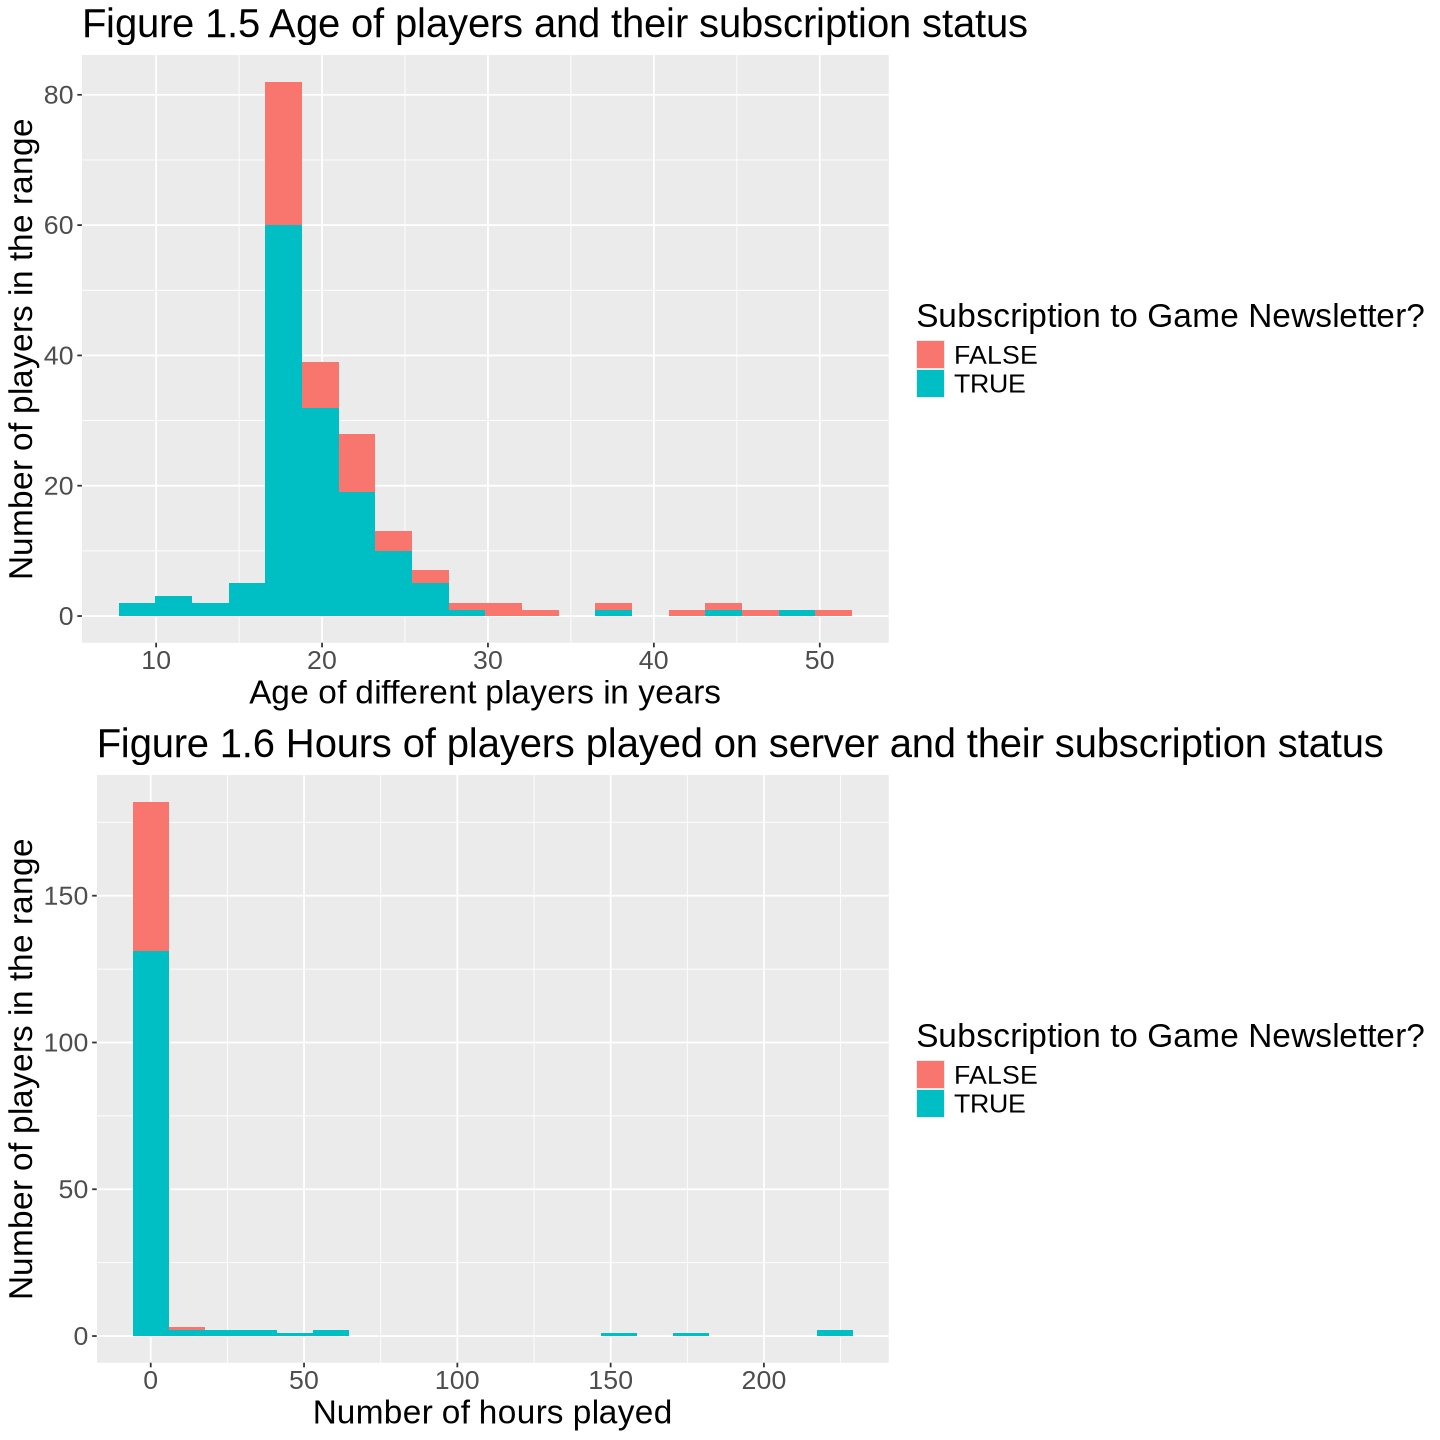

In [8]:
library(cowplot)

age_hist <- ggplot(players, aes(x=Age, fill = as_factor(subscribe))) +
                geom_histogram(bins=20) +
                labs(x="Age of different players in years",
                     y="Number of players in the range",
                    fill="Subscription to Game Newsletter?",
                    title = "Figure 1.5 Age of players and their subscription status") +
                    theme(text=element_text(size=20))

played_hours_hist <- ggplot(players, aes(x=played_hours, fill = as_factor(subscribe))) +
                geom_histogram(bins=20) +
                labs(x="Number of hours played",
                     y="Number of players in the range",
                    fill="Subscription to Game Newsletter?",
                    title = "Figure 1.6 Hours of players played on server and their subscription status") +
                    theme(text=element_text(size=20))

plot_grid(age_hist, played_hours_hist, ncol=1)

#### Explanation of Figure 1.5 and Figure 1.6:
The first histogram (Figure 1.5) shows that most players are between 15 and 25 years old, with a higher proportion of subscribed players (blue) in this range. Few players are older than 30, and subscription rates appear to decline with age. This is consistent with our understanding of the data, as there are most younger audience that subscribed compared to older players.

The second histogram (Figure 1.6) highlights that most players have very low playtime, with a small number of outliers playing significantly more. Subscription status seems to have some impact on engagement, as a larger share of subscribed players have higher playtime compared to non-subscribers (i.e players with over 25-30 played hours all seem to be subscribed to game newsletters). However, overall, engagement remains low for most players in this dataset, regardless of subscription.

## Data Analysis

### Methods
#### Part 1: The data
1. To use knn classification to determine subscription status, the classification was set to factor and not logical. There are some players who don't have an age, so they were removed from the dataset as well.
2. `Age` and `played_hours` were chosen as the two predictors to the response variable, `subscribe` because we felt like those two variables were the most indicative of `subscribe` in the dataset. From the figures provided above (e.x. Figure 1.4, 1.5 and 1.6), we are able to see there are some correlations between the predictors and the response variable. For example, we saw trends where increased played hours usually yields `subscribe=TRUE`, and players with a younger age typically have a higher chance of subscribing to game newsletter compared to those that are older.

#### Part 2: Classification - testing k 
1. A random seed was added to increase the reproducibility of the notebook
2. A recipe was structured to predict subscription status from age and hours played. Both predictors were scaled and centered, and <code>tune()</code> was used to test different k values. We show that why trying to use `step_upsample` doesn't yield the results we would like to see.
3. In order to find the optimal number of nearest neighbours, the data was split into training and testing sets, 75% training to 25% test data.
4. With consideration for accuracy and computation time, V-fold with v = 5 was used for cross validation of different k values.
5. k's were generated by the odd numbers between 1 and 41, and the model calculated nearest neighbour by linear distance (<code>weight_func = "rectangular"</code>) and both predictors contributed equally to the distance calculation, due to the standarization done in the recipe.
6. A workflow was created for the tuned model, and the metrics for each k were collected with <code>collect_metrics()</code>.
7. The k values were plotted against accuracy extracted from <code>collect_metrics()</code> to find the relative peaks.

#### Part 3: Adjusting k
1. The k value with the highest accuracy is <code>k = 15</code>. The model was refitted with this value for k. A confusion matrix was produced along with a graph displaying whether or not the data points were correctly assigned.

2. With <code>k = 15</code>, the model predicts nearly all the points in the testing set as <code>TRUE</code>. All the <code>FALSE</code> data points were incorrectly assigned as <code>TRUE</code>. This is an issue because a majority of the players in the database are subscribed-- there are not enough players that are not subscribed to be the majority of 15 neighbours. In order to avoid this, we can try to address this class imbalance by using <code>step_upsample</code> in our knn recipe and adjust the number of observations we have that are not subscribed, or we could try to choose some smaller k (e.g 9).

In [9]:
# Part 1: The data

#change subsription status to be a factor rather than logical, and remove ages that aren't numbers
players_mod <- mutate(players,subscribe = as_factor(subscribe))|>
    filter(Age > 0)
players_mod

summary_players <- players_mod |>
    group_by(subscribe) |>
    summarize(count = n(), average_played_hours = mean(played_hours), average_age = mean(Age))
summary_players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17


subscribe,count,average_played_hours,average_age
<fct>,<int>,<dbl>,<dbl>
FALSE,52,0.5019231,22.98077
TRUE,142,7.8830986,19.61972


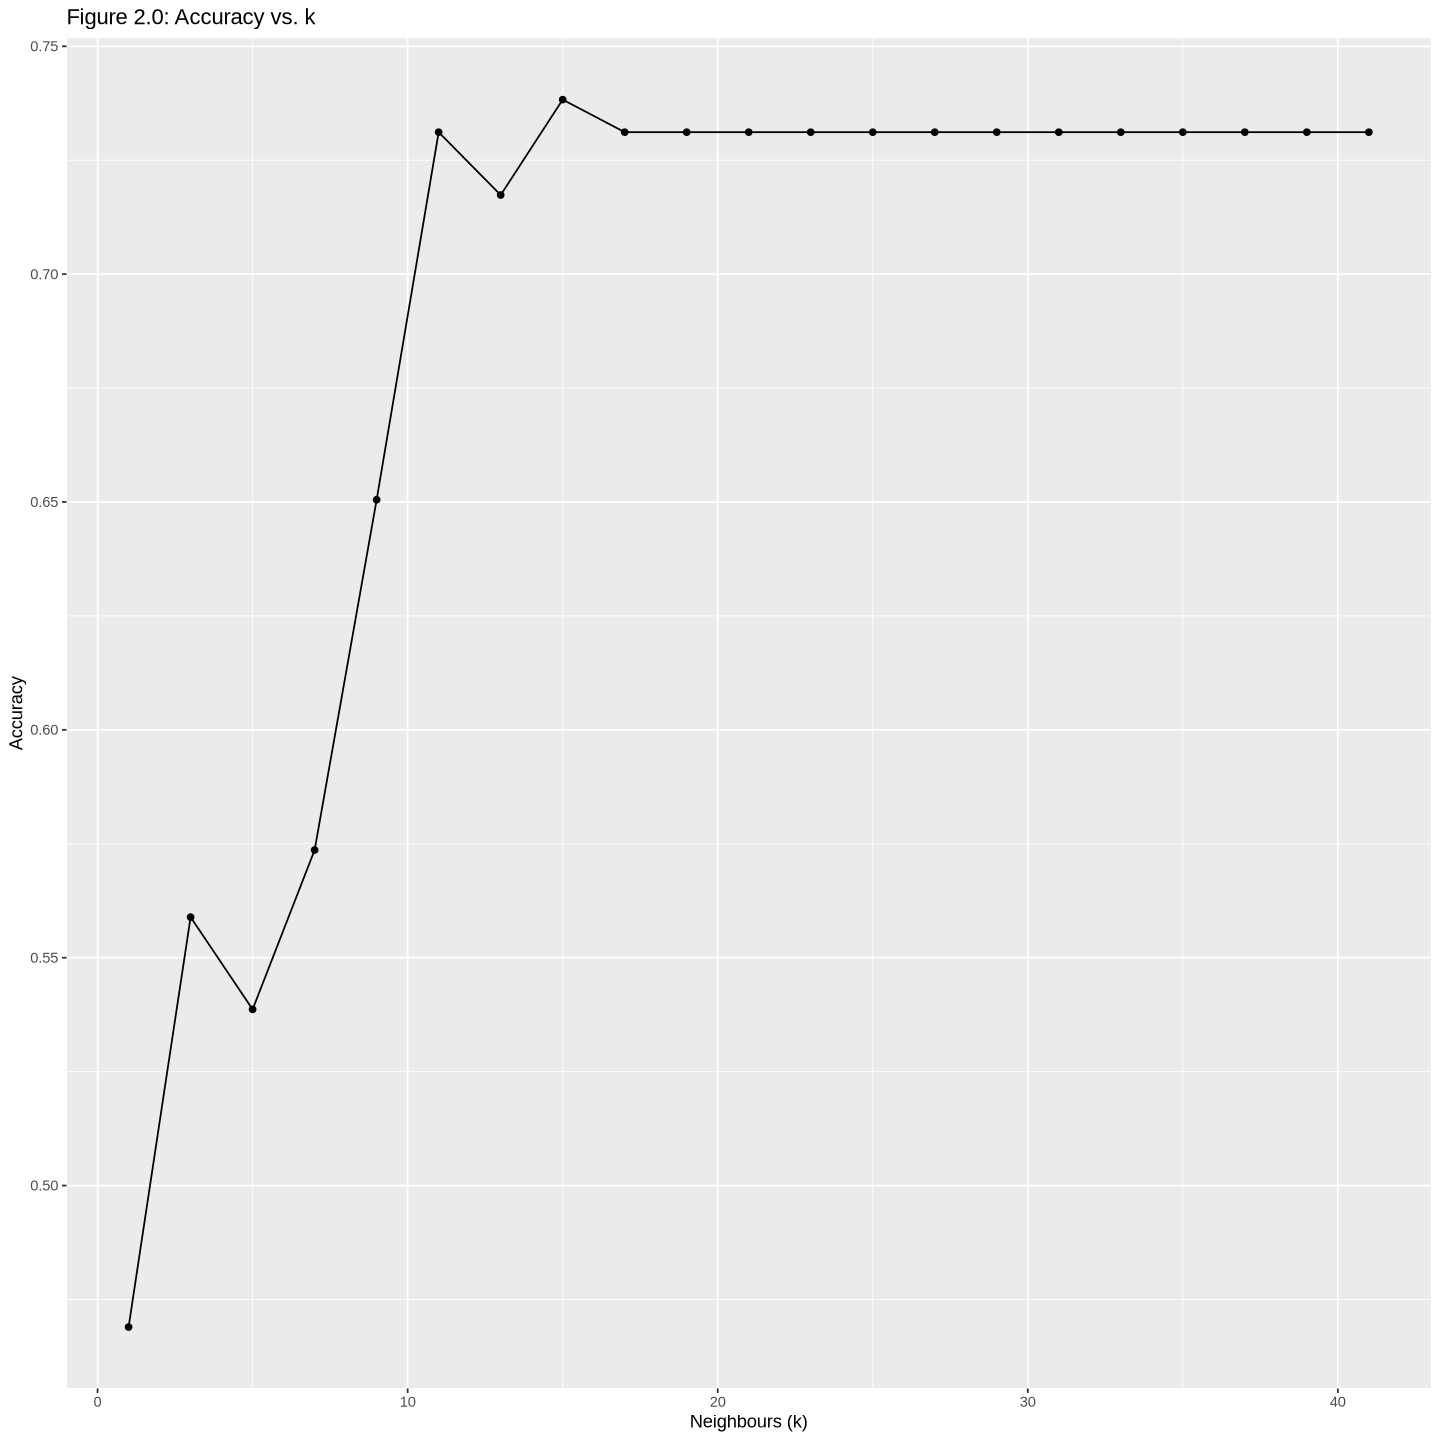

In [10]:
# Part 2: Classification - testing k

set.seed(5555)

#players recipe
players_recipe <- recipe(subscribe~ Age + played_hours, data = players_mod)|>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

#split data with training and testing
players_split <- initial_split(players_mod, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

#v_fold
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

#model specifications and set values for k
k_vals <- tibble(neighbors = seq(from = 1, to = 41, by = 2))

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn")|>
    set_mode("classification")

#test k values
k_test <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

#plot k and accuracy
k_plot <- k_test |>
    filter(.metric =="accuracy") |>
    ggplot(aes(x = neighbors, y = mean))+
    geom_point()+
    geom_line()+
    labs(x = "Neighbours (k)", y = "Accuracy")+
    ggtitle("Figure 2.0: Accuracy vs. k")

k_plot


.pred_class,subscribe,Age,played_hours,correct
<fct>,<fct>,<int>,<dbl>,<fct>
TRUE,TRUE,9,30.3,TRUE
TRUE,TRUE,17,3.8,TRUE
TRUE,FALSE,17,0.0,FALSE
⋮,⋮,⋮,⋮,⋮
TRUE,FALSE,17,0.0,FALSE
TRUE,TRUE,17,0.1,TRUE
TRUE,TRUE,20,0.0,TRUE


          Truth
Prediction FALSE TRUE
     FALSE     0    2
     TRUE     13   34

neighbors,.metric,mean
<dbl>,<chr>,<dbl>
15,accuracy,0.7382923


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7234043


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9444444


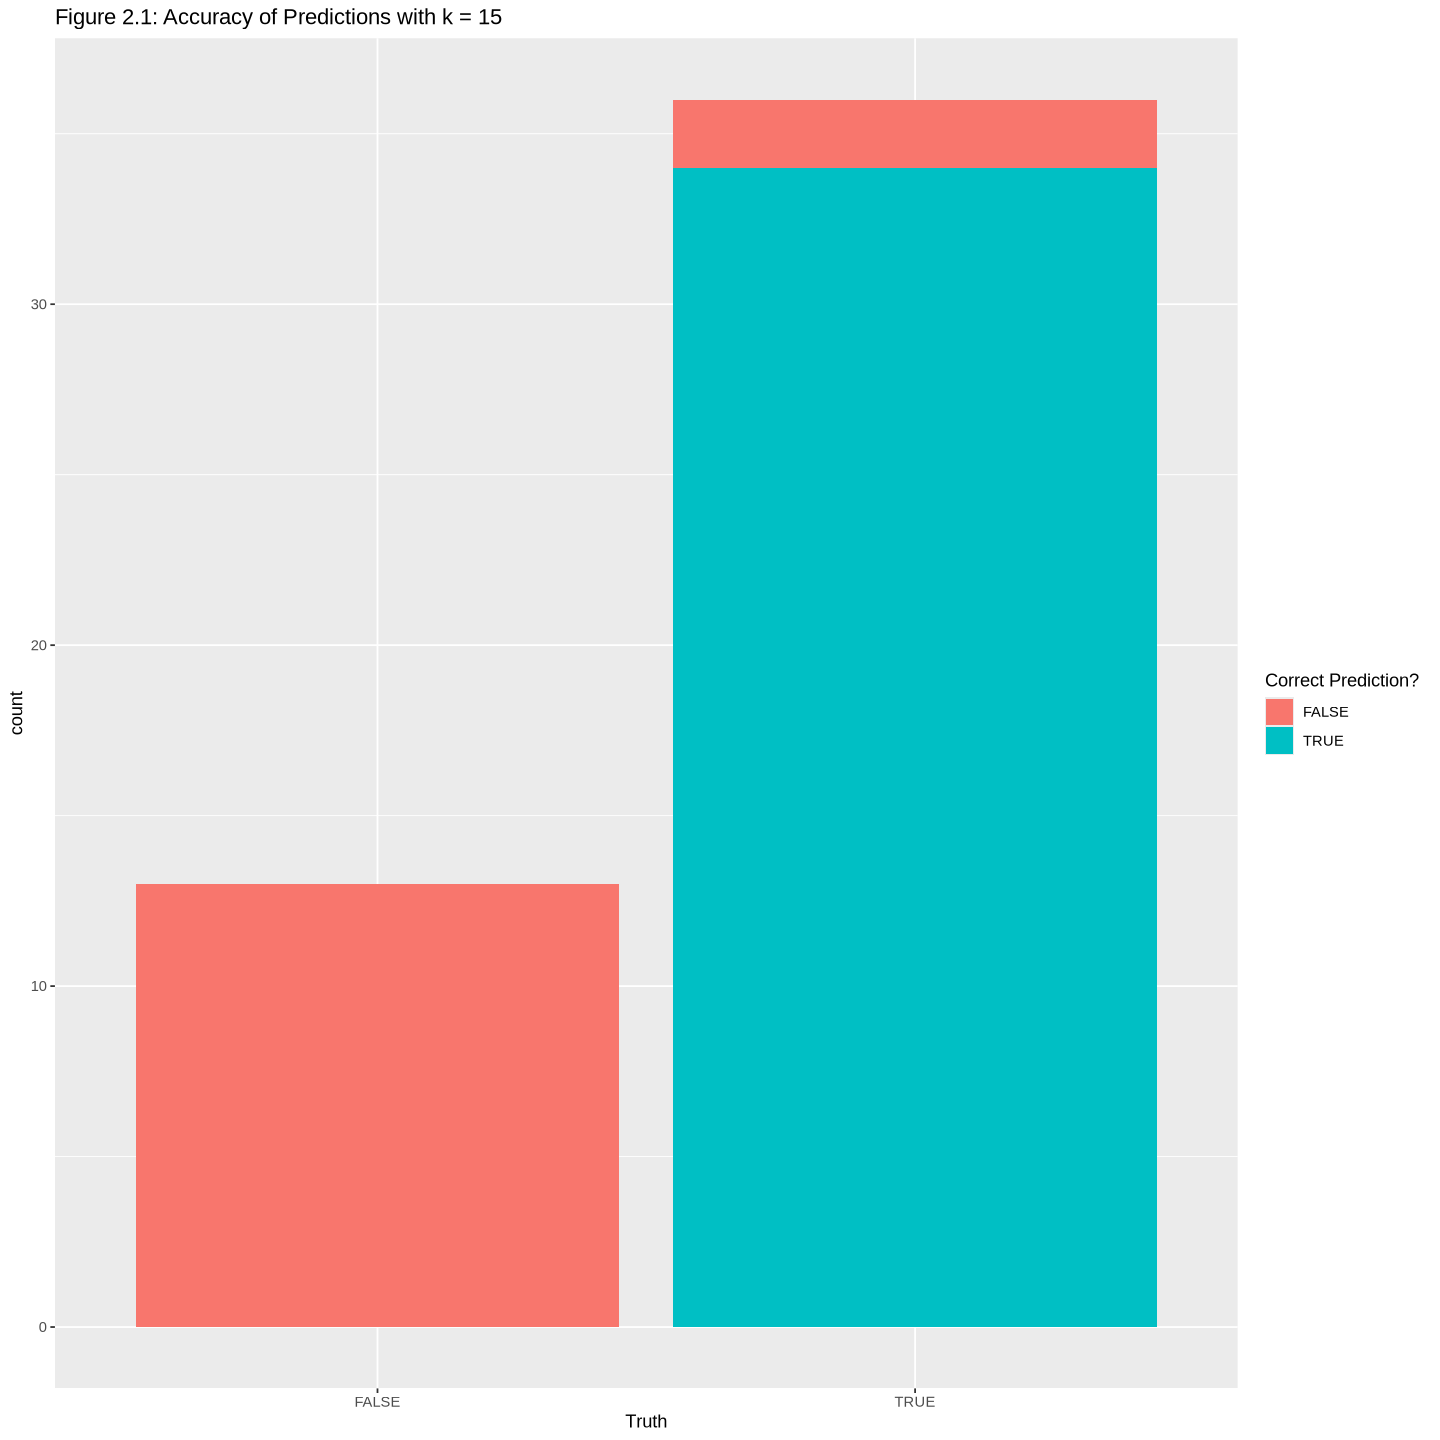

In [11]:
# Part 3: Adjusting k (k = 15)

#best fit k is 15, adjust spec to fit
knn_spec_15 <-  nearest_neighbor(weight_func = "rectangular", neighbors = 15) |>
    set_engine("kknn")|>
    set_mode("classification")

#workflow k=15 trained 
players_workflow_15 <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_15) |>
    fit(data = players_train)

#check workflow on testing data
predictions_15 <- predict(players_workflow_15, players_test)|>
    bind_cols(players_test)|>
    select(.pred_class, subscribe, Age, played_hours)|>
    mutate(correct = as_factor(.pred_class == subscribe))
predictions_15

#confusion matrix
table_15 <- predictions_15 |>
    conf_mat(truth = subscribe, estimate = .pred_class)
table_15

#plot predictions
plot_15 <- predictions_15 |>
    ggplot(aes(x = subscribe, fill = correct))+
    geom_bar()+
    labs(x = "Truth", 
         fill = "Correct Prediction?",
         title = "Figure 2.1: Accuracy of Predictions with k = 15")
plot_15

#accuracy
accuracy_15 <- k_test|>
    filter(neighbors==15, .metric == "accuracy")|>
    select(neighbors,.metric,mean)
accuracy_15

#precision
precision_15 <- predictions_15 |>
                precision(truth = subscribe, estimate = .pred_class, event_level = "second")
precision_15
#recall
recall_15 <- predictions_15 |>
                recall(truth = subscribe, estimate = .pred_class, event_level = "second")
recall_15

.pred_class,subscribe,Age,played_hours,correct
<fct>,<fct>,<int>,<dbl>,<fct>
TRUE,TRUE,9,30.3,TRUE
TRUE,TRUE,17,3.8,TRUE
FALSE,FALSE,17,0.0,TRUE
⋮,⋮,⋮,⋮,⋮
FALSE,FALSE,17,0.0,TRUE
TRUE,TRUE,17,0.1,TRUE
TRUE,TRUE,20,0.0,TRUE


          Truth
Prediction FALSE TRUE
     FALSE     5    3
     TRUE      8   33

neighbors,.metric,mean
<dbl>,<chr>,<dbl>
9,accuracy,0.6504926


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.804878


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9166667


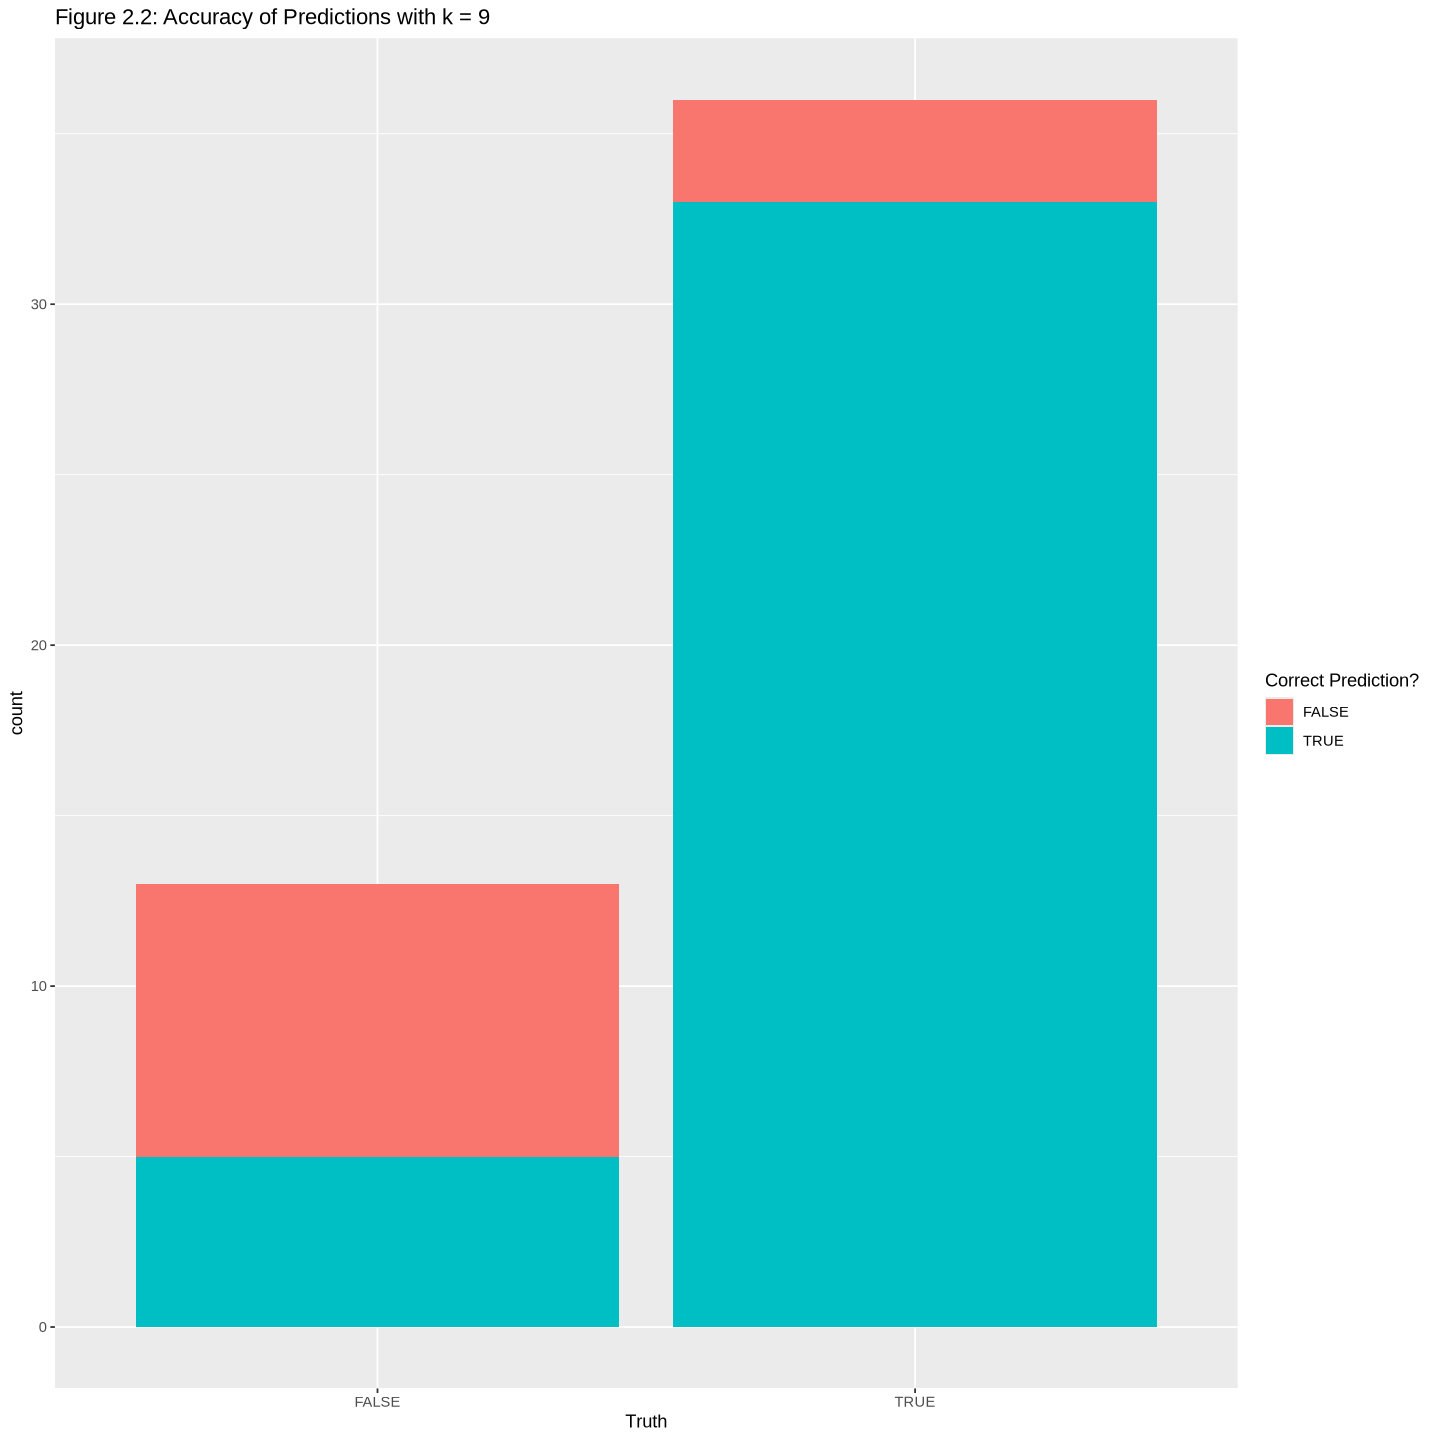

In [12]:
# Part 3: Adjusting k (k = 9)

#trying k=9, adjust spec to fit
knn_spec_9 <-  nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn")|>
    set_mode("classification")

#workflow k=9 trained 
players_workflow_9 <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec_9) |>
    fit(data = players_train)

#check workflow on testing data
predictions_9 <- predict(players_workflow_9, players_test)|>
    bind_cols(players_test)|>
    select(.pred_class, subscribe, Age, played_hours) |>
    mutate(correct = as_factor(.pred_class == subscribe))
predictions_9

#confusion matrix
table_9 <- predictions_9 |>
    conf_mat(truth = subscribe, estimate = .pred_class)
table_9

#plot predictions
plot_9 <- predictions_9 |>
    ggplot(aes(x = subscribe, fill = correct))+
    geom_bar()+
    labs(x = "Truth", 
         fill = "Correct Prediction?", 
         title = "Figure 2.2: Accuracy of Predictions with k = 9",)
plot_9

#accuracy
accuracy_9 <- k_test|>
    filter(neighbors==9, .metric == "accuracy")|>
    select(neighbors,.metric,mean)
accuracy_9

#precision
precision_9 <- predictions_9 |>
                precision(truth = subscribe, estimate = .pred_class, event_level = "second")
precision_9
#recall
recall_9 <- predictions_9 |>
                recall(truth = subscribe, estimate = .pred_class, event_level = "second")
recall_9

### Results from the predictive analysis

With k = 15, accuracy was assessed as 73.8%. A majority of the testing data where subscribe = TRUE were predicted correctly, but all of the testing data where subscribe = FALSE were predicted incorrectly (Figure 2.1). After adjusting to k = 9, the accuracy decreased to 65.0%. The majority of subscribed profiles were predicted correctly, but the majority of non-subscribed profiles were predicted incorrectly. Decreasing k did help more points to be predicted FALSE, but it sacrificed accuracy. However, we can see a comparison of the precision and recall yielded from both k values.

In [13]:
precision_9
precision_15
recall_9
recall_15
table_9

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.804878


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.7234043


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9166667


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9444444


          Truth
Prediction FALSE TRUE
     FALSE     5    3
     TRUE      8   33

Where the first two tibbles are comparision of precision between $k=9$ and $k=15$, and the latter two are a comparison of recall of the knn model between $k=9$ and $k=15$. The last confusion matrix is the confusion matrix for $k=9$. Although the accuracy and recall of the knn model with $k=9$ is slight lower than the knn model for $k=15$, we can see that the precision is higher for $k=9$ <b>(why is precision valuable?)</b>. We need to note that for $k=15$, the model is then just predicting TRUE for any observations, which is the reason that it has such a high recall and accuracy, but it is not practical at all. So in a sense, $k=9$ should be a more optimal parameter, as it has high recall and precision with only a slightly decreased accuracy. 

Thus, with a $65.0%$ accuracy, the model using $k=9$ offers a more balanced and practical approach compared to $k=15$. While it slightly sacrifices accuracy, it avoids the pitfall of overpredicting the majority class (i.e., always predicting TRUE), and instead provides stronger precision meaning when it predicts a player is subscribed, it's more likely to be correct. This makes the model more reliable in real world applications, where false positives can lead to inefficient targeting efforts. Overall, $k=9$ provides a better trade-off between precision and recall, making it a more suitable choice for identifying actual newsletter subscribers.

## Final Discussions and concluding thoughts

From the predictive analysis, we found that our KNN model has an accuracy of 65%. This indicates that age and played hours of a specific player do influence the prediction of the player's subscription status to game newsletters.

Was this expected?

Yes, this is what we expected to find as from our visualizations, we observed the trend that younger players tend to have higher played hours and also be subscribed to the newsletter. However, the accuracy result from the model suggests that there is difficulty with identifying non-subscribed players due to class imbalance. Because of this, while age and played hours are factors that influence subscription status, additional factors should be considered for more accurate predictions and performance. 

What impact could such findings have?

These findings could be useful for the researchers of this game that are trying to increase the subscriptions to newsletter and overall player engagement. By gaining this understanding that younger players will more likely spend a higher number of played hours and subscribe, the researchers are able to better target their recruitment efforts.

What future questions could this lead to?

The results lead to several future questions that could further improve the accuracy of our predictions and understanding of player behavior. For example, what additional features can be added? In game purchases, social interactions, or session frequency might contribute to predicting newsletter subscription more effectively? Additionally, it would be worth exploring what specific content or timing of the newsletters appeals to subscribed players, and whether these preferences differ by age group or play style. This could help in designing more targeted and engaging newsletters.